In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [34]:
# Charger le fichier CSV
ocpp = pd.read_csv('ocpp.csv')

sessions = pd.read_csv('sessions.csv')

In [35]:
# Assurer que la colonne 'charge_date' est au bon format datetime
sessions['charge_date'] = pd.to_datetime(sessions['charge_date'])

# Filtrer pour charger_id '37A80B4D' et charge_date '2023-01-23'
charger_data = sessions[(sessions['charger_id'] == '37A80B4D') & (sessions['charge_date'] == '2023-01-23')]

# Afficher le résultat
print(charger_data)

       charge_date charger_id  connector_id  sessions  failed_sessions
1       2023-01-23   37A80B4D             3         3                3
461     2023-01-23   37A80B4D             2        10                0
432971  2023-01-23   37A80B4D             1         1                0


In [36]:
# Assurer que la colonne 'charge_date' est au bon format datetime
ocpp['charge_date'] = pd.to_datetime(ocpp['error_at'])

# Filtrer pour charger_id '37A80B4D' et charge_date '2023-01-23'
ocpp_data = ocpp[(ocpp['charger_id'] == '37A80B4D') & (ocpp['error_at'] == '2023-01-23')]

# Afficher le résultat
print(ocpp_data)

Empty DataFrame
Columns: [supplier, charger_id, connector_id, error_code, vendor_error_code, total_error_notifications, error_at, charge_date]
Index: []


In [37]:
# Calcul de la variable target
sessions['target'] = (sessions['failed_sessions'] / sessions['sessions']) + (1 / (1 + sessions['sessions']))

# Limiter la target entre 0 et 1 (si nécessaire)
sessions['target'] = sessions['target'].clip(0, 1)

# Afficher les premières lignes
print(sessions[['charge_date', 'charger_id', 'connector_id', 'sessions', 'failed_sessions', 'target']].head())


  charge_date charger_id  connector_id  sessions  failed_sessions    target
0  2023-01-16   34406128             5         4                0  0.200000
1  2023-01-23   37A80B4D             3         3                3  1.000000
2  2023-01-18   AA92D18E             2         2                0  0.333333
3  2023-01-28   FF15DC0B             3         2                0  0.333333
4  2023-01-19   06B95C56             2         1                0  0.500000


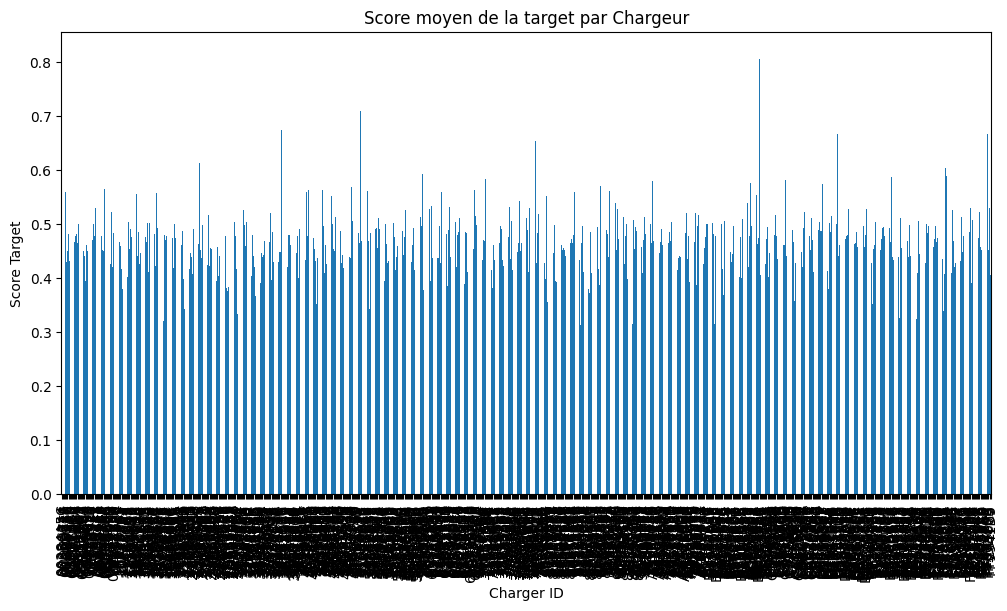

In [38]:
# Visualisation de la distribution de la target pour chaque chargeur
plt.figure(figsize=(12, 6))
sessions.groupby('charger_id')['target'].mean().plot(kind='bar')
plt.title('Score moyen de la target par Chargeur')
plt.xlabel('Charger ID')
plt.ylabel('Score Target')
plt.show()

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour calculer la target
def metric1(chargeur_id, connector_id, sessions):
    """
    Calcule la target pour un chargeur et un connecteur donnés.
    
    Args:
        chargeur_id (str): L'ID du chargeur.
        connector_id (int): L'ID du connecteur.
        sessions (DataFrame): Le DataFrame contenant les données de sessions.
        
    Returns:
        pd.Series: La target calculée pour chaque ligne filtrée des sessions.
    """
    # Filtrer les données pour ce chargeur et connecteur spécifiques
    filtered_sessions = sessions[(sessions['charger_id'] == chargeur_id) & (sessions['connector_id'] == connector_id)]
    
    # Calculer la target pour chaque ligne
    filtered_sessions['target'] = (filtered_sessions['failed_sessions'] / filtered_sessions['sessions']) + (1 / (1 + filtered_sessions['sessions']))
    
    # Limiter la target entre 0 et 1
    #filtered_sessions['target'] = filtered_sessions['target'].clip(0, 1)
    max = np.max(filtered_sessions['target'])
    filtered_sessions['target']=filtered_sessions['target']/max
    return filtered_sessions

def metric2(chargeur_id, connector_id, sessions):
    """
    Calcule la target pour un chargeur et un connecteur donnés.
    
    Args:
        chargeur_id (str): L'ID du chargeur.
        connector_id (int): L'ID du connecteur.
        sessions (DataFrame): Le DataFrame contenant les données de sessions.
        
    Returns:
        pd.Series: La target calculée pour chaque ligne filtrée des sessions.
    """
    # Filtrer les données pour ce chargeur et connecteur spécifiques
    filtered_sessions = sessions[(sessions['charger_id'] == chargeur_id) & (sessions['connector_id'] == connector_id)]
    
    # Calculer la target pour chaque ligne
    failure_rate=(filtered_sessions['failed_sessions'] / filtered_sessions['sessions'])
    filtered_sessions['target'] =-np.log(1-failure_rate)*np.sqrt(filtered_sessions['sessions'])
    
    # Limiter la target entre 0 et 1
    #filtered_sessions['target'] = filtered_sessions['target'].clip(0, 1)
    max = np.max(filtered_sessions['target'])
    filtered_sessions['target']=filtered_sessions['target']/max
    return filtered_sessions



C:\Users\Titouan\AppData\Local\Temp\ipykernel_16604\2173761356.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sessions['target'] = (filtered_sessions['failed_sessions'] / filtered_sessions['sessions']) + (1 / (1 + filtered_sessions['sessions']))
C:\Users\Titouan\AppData\Local\Temp\ipykernel_16604\2173761356.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sessions['target']=filtered_sessions['target']/max


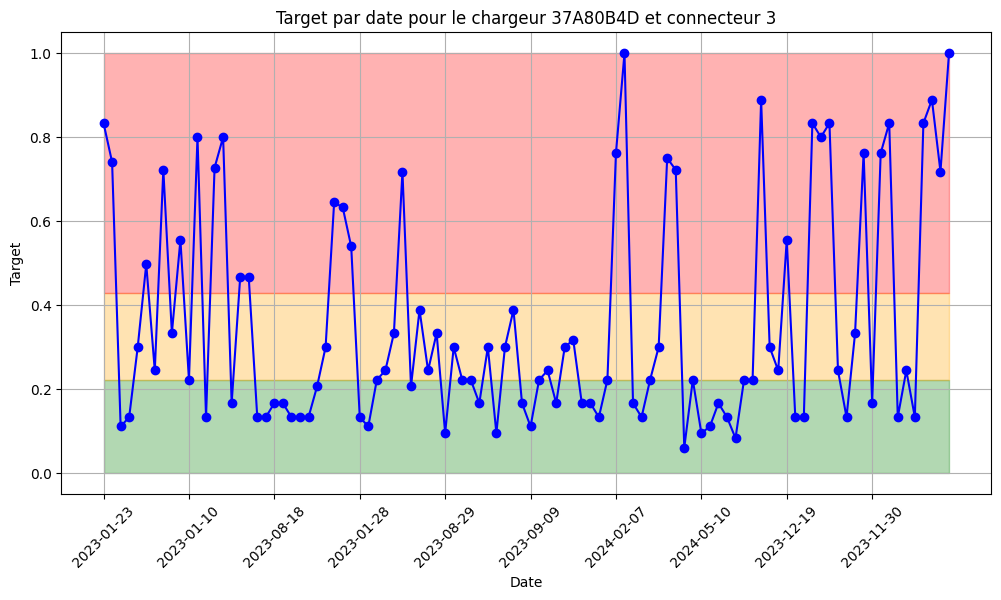

In [74]:
# Charger les fichiers CSV
sessions = pd.read_csv('sessions.csv')
ocpp = pd.read_csv('ocpp.csv')

# Définir le chargeur et le connecteur que tu souhaites analyser
chargeur_id = '37A80B4D'  # Remplace par l'ID du chargeur que tu veux analyser
connector_id = 3  # Remplace par l'ID du connecteur que tu veux analyser

# Utiliser la fonction metric pour obtenir les données avec la target
filtered_sessions = metric1(chargeur_id, connector_id, sessions)

#Calculer les quantiles pour déterminer les bornes dynamiques
q1 = filtered_sessions['target'].quantile(0.40)  # 25e percentile
q2 = filtered_sessions['target'].quantile(0.65)   # 50e percentile (médiane)
#q3 = filtered_sessions['target'].quantile(0.75)  # 75e percentile

# Plot de la target par date
plt.figure(figsize=(12, 6))

# Remplir les zones selon la target
plt.fill_between(filtered_sessions['charge_date'][:100], 0, q1, color='green', alpha=0.3, label="Bonne zone (0-0.2)")
plt.fill_between(filtered_sessions['charge_date'][:100], q1, q2, color='orange', alpha=0.3, label="Zone moyenne (0.2-0.6)")
plt.fill_between(filtered_sessions['charge_date'][:100], q2, 1, color='red', alpha=0.3, label="Mauvaise zone (0.6-1)")

plt.plot(filtered_sessions['charge_date'][:100], filtered_sessions['target'][:100], marker='o', linestyle='-', color='b')
plt.title(f"Target par date pour le chargeur {chargeur_id} et connecteur {connector_id}")
plt.xlabel('Date')
plt.ylabel('Target')

# Afficher une date sur chaque 10ème tick
plt.xticks(filtered_sessions['charge_date'][:100:10], rotation=45)  # Prendre chaque 10ème date
plt.grid(True)
plt.show()